In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree         import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [3]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
print(df.shape)
print(df.info())
print(df['stroke'].value_counts(normalize=True))

df.isna().sum()

(5110, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB
None
stroke
0    0.951272
1    0.048728
Name: proportion, dtype: float64


id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [5]:
df = df.drop(columns=['id'])
df['bmi'] = df['bmi'].fillna(df['bmi'].median())

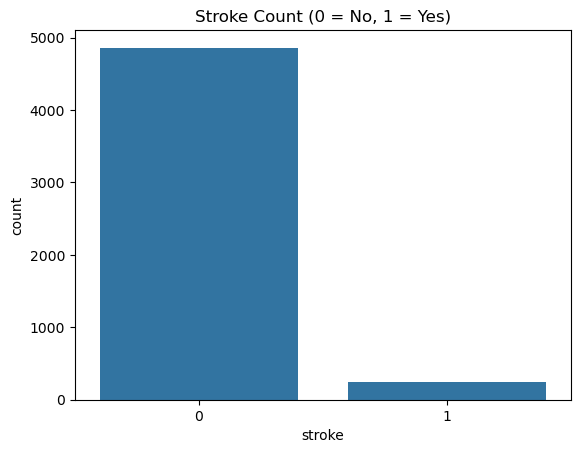

In [6]:
sns.countplot(x='stroke', data=df)
plt.title('Stroke Count (0 = No, 1 = Yes)')
plt.show()

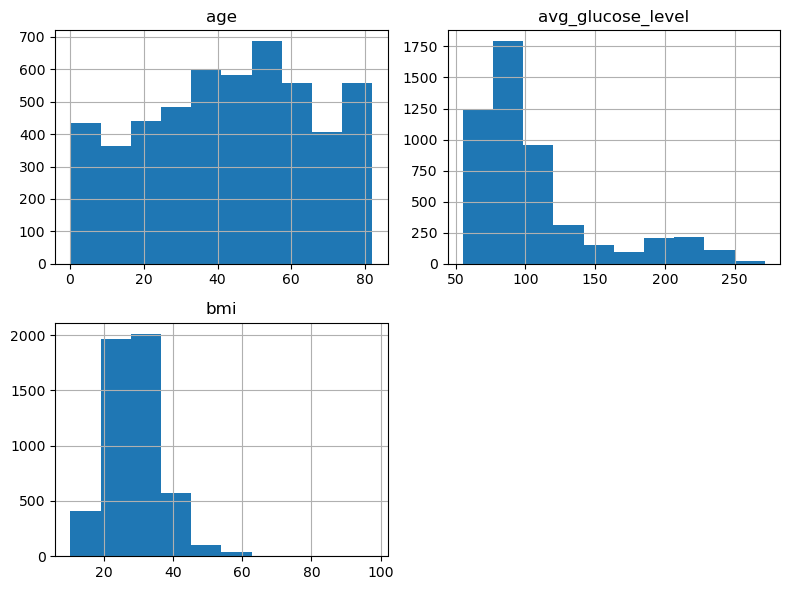

In [7]:
num_feats = ['age', 'avg_glucose_level', 'bmi']
df[num_feats].hist(figsize=(8,6))
plt.tight_layout()
plt.show()

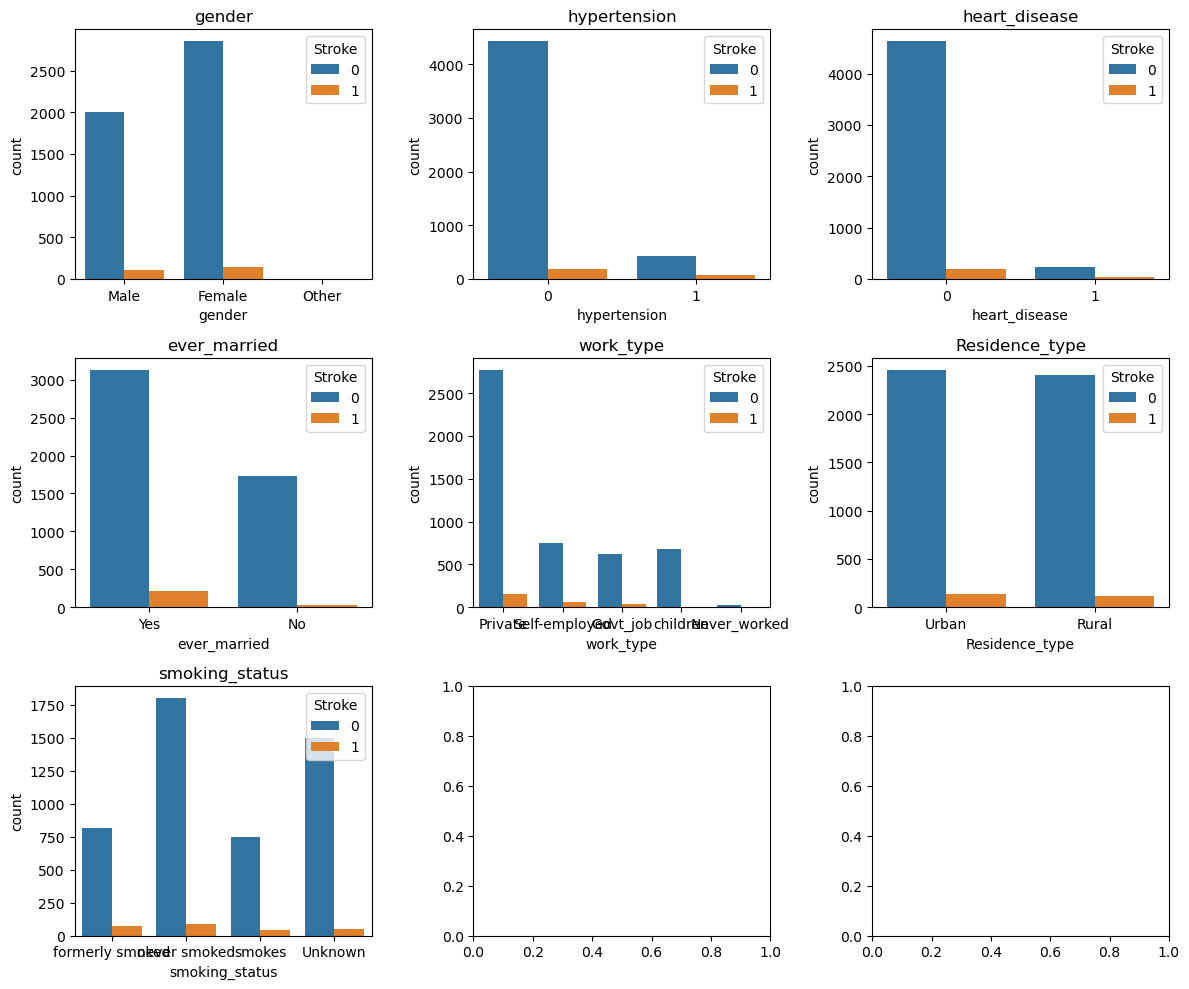

In [8]:
cat_feats = ['gender', 'hypertension', 'heart_disease', 'ever_married', 
            'work_type', 'Residence_type', 'smoking_status']

fig, axes = plt.subplots(3, 3, figsize=(12,10))
for ax, col in zip(axes.flatten(), cat_feats):
    sns.countplot(x=col, hue='stroke', data=df, ax=ax)
    ax.set_title(col)
    ax.legend(title='Stroke', loc='upper right')
plt.tight_layout()
plt.show()

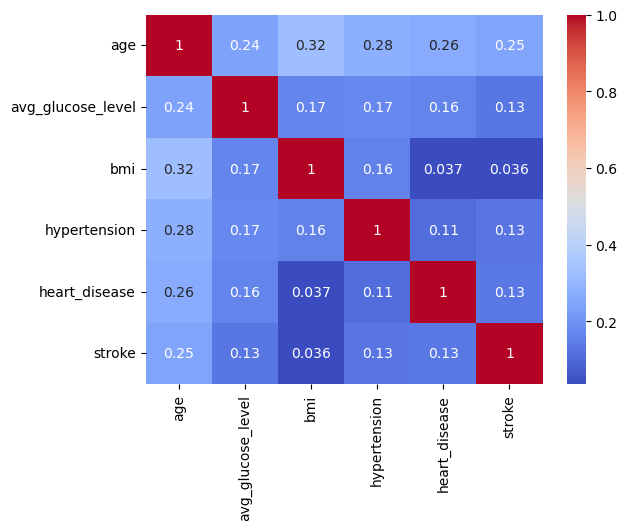

In [9]:
corr = df[num_feats + ['hypertension','heart_disease','stroke']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()


# Modeling

In [10]:
num_feats = ['age', 'avg_glucose_level', 'bmi']
cat_feats = ['gender','hypertension','heart_disease',
            'ever_married','work_type','Residence_type','smoking_status']

X = df.drop('stroke', axis=1)
y = df['stroke']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train[num_feats] = scaler.fit_transform(X_train[num_feats])
X_test[num_feats]  = scaler.transform(   X_test[num_feats])

In [11]:
X_train = pd.get_dummies(X_train, columns=cat_feats, drop_first=False)
X_test  = pd.get_dummies(X_test,  columns=cat_feats, drop_first=False)

X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

In [12]:
rf = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

rf_preds = rf.predict(X_test)
rf_probs = rf.predict_proba(X_test)[:,1]

print("===== Random Forest =====")
print(classification_report(y_test, rf_preds, digits=4))
print("ROC AUC:", roc_auc_score(y_test, rf_probs))
print("Confusion Matrix:\n", confusion_matrix(y_test, rf_preds), "\n")


===== Random Forest =====
              precision    recall  f1-score   support

           0     0.9510    0.9979    0.9739       972
           1     0.0000    0.0000    0.0000        50

    accuracy                         0.9491      1022
   macro avg     0.4755    0.4990    0.4869      1022
weighted avg     0.9045    0.9491    0.9262      1022

ROC AUC: 0.7602777777777778
Confusion Matrix:
 [[970   2]
 [ 50   0]] 



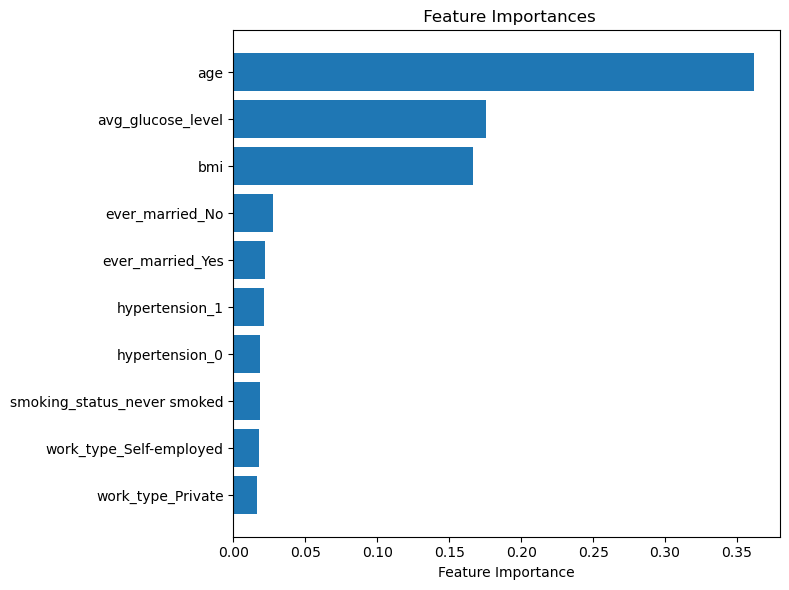

In [17]:
importances = rf.feature_importances_
features    = X_train.columns

top_n   = 10
indices = np.argsort(importances)[::-1][:top_n]
top_feats = features[indices]
top_importances = importances[indices]

plt.figure(figsize=(8, 6))
plt.barh(top_feats[::-1], top_importances[::-1])
plt.xlabel("Feature Importance")
plt.title(" Feature Importances")
plt.tight_layout()
plt.show()

In [14]:
lr = LogisticRegression(
    penalty='l2',
    C=1.0,
    class_weight='balanced',
    max_iter=1000,
    random_state=42
)
lr.fit(X_train, y_train)

lr_preds = lr.predict(X_test)
lr_probs = lr.predict_proba(X_test)[:,1]

print("=== Logistic Regression ===")
print(classification_report(y_test, lr_preds, digits=4))
print("ROC AUC:", roc_auc_score(y_test, lr_probs))
print("Confusion Matrix:\n", confusion_matrix(y_test, lr_preds), "\n")


=== Logistic Regression ===
              precision    recall  f1-score   support

           0     0.9863    0.7428    0.8474       972
           1     0.1379    0.8000    0.2353        50

    accuracy                         0.7456      1022
   macro avg     0.5621    0.7714    0.5414      1022
weighted avg     0.9448    0.7456    0.8175      1022

ROC AUC: 0.8437448559670782
Confusion Matrix:
 [[722 250]
 [ 10  40]] 



In [15]:
dtc = DecisionTreeClassifier(
    class_weight='balanced',
    random_state=42
)
dtc.fit(X_train, y_train)

dtc_preds = dtc.predict(X_test)
dtc_probs = dtc.predict_proba(X_test)[:,1]

print("==== Decision Tree ==== ")
print(classification_report(y_test, dtc_preds, digits=4))
print("ROC AUC:", roc_auc_score(y_test, dtc_probs))
print("Confusion Matrix:\n", confusion_matrix(y_test, dtc_preds))

==== Decision Tree ==== 
              precision    recall  f1-score   support

           0     0.9555    0.9722    0.9638       972
           1     0.1818    0.1200    0.1446        50

    accuracy                         0.9305      1022
   macro avg     0.5687    0.5461    0.5542      1022
weighted avg     0.9177    0.9305    0.9237      1022

ROC AUC: 0.5461111111111112
Confusion Matrix:
 [[945  27]
 [ 44   6]]
